In [113]:
%matplotlib inline
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Flatten, Dropout, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU

import os
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

import math

import matplotlib.pyplot as plt

In [82]:
def generator_model():
    model = Sequential()
    # Generatorへのランダム入力は100次元のノイズベクトル
    model.add(Dense(input_dim=100, units=1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128 * 7 * 7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128 * 7 * 7, )))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

In [31]:
generator = generator_model()
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_26 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_31 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_27 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_32 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 7, 7, 128)         0         
__________

In [112]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5),
                     strides=(2, 2),
                     padding='same',
                     input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (5, 5), strides=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [75]:
discriminator = discriminator_model()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               819456    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 256)               0         
__________

In [102]:
def combine_images(generated_images):
    """
    benerated_images: (batches, height, width, channels)
    """
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total) / cols)
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((height * rows, width * cols),
                              dtype=generated_images.dtype)
    for index, image in enumerate(generated_images):
        i = int(index / cols)
        j = index % cols
        combined_image[width * i:width * (i + 1), height * j:height * (j + 1)] = image[:, :, 0]
    return combined_image

In [94]:
BATCH_SIZE = 36
NUM_EPOCH = 20
GENERATED_IMAGE_PATH = 'generated_images/'
MODEL_PATH = 'models/'

if not os.path.exists(GENERATED_IMAGE_PATH):
    os.mkdir(GENERATED_IMAGE_PATH)

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# MNISTをロード
(X_train, y_train), (_, _) = mnist.load_data()
# [-1.0, 1.0] に正規化
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
# (batch, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

# discriminatorのみのモデル構築
discriminator = discriminator_model()
d_opt = Adam(lr=1e-5, beta_1=0.1)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)
discriminator.summary()

# generator + discriminatorのモデル構築
# discriminatorの重みは固定（固定されるのはdcganの中のdiscriminatorのみ）
# trainableを反映させるにはcompile()が必要
# summary()表示するとわかる
discriminator.trainable = False
generator = generator_model()
# generatorが生成した画像をdiscriminatorが予測
dcgan = Sequential([generator, discriminator])
g_opt = Adam(lr=2e-4, beta_1=0.5)
dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)
dcgan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 256)               819456    
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 256)               0         
__________

In [101]:
num_batches = int(X_train.shape[0] / BATCH_SIZE)
print('Number of batches:', num_batches)

d_loss_history = []
g_loss_history = []

for epoch in range(NUM_EPOCH):
    for index in range(num_batches):
        # Generatorへの入力となるノイズベクトルをバッチサイズ分作成
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        
        # 本物の画像（訓練データ）
        image_batch = X_train[index * BATCH_SIZE:(index + 1) * BATCH_SIZE]
        
        # 生成画像
        generated_images = generator.predict(noise, verbose=0)

        # discriminatorを更新
        # discriminatorの出力は本物の画像である確率なので本物の画像のラベルは1、生成画像のラベルは0
        X = np.concatenate((image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        d_loss = discriminator.train_on_batch(X, y)
        d_loss_history.append(d_loss)

        # generatorを更新
        # generatorは生成画像が本物の画像（ラベル1）と認識されたいため理想となる正解ラベルは1になる
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        g_loss = dcgan.train_on_batch(noise, [1] * BATCH_SIZE)
        g_loss_history.append(g_loss)

        print('epoch: %d, batch: %d, g_loss: %f, d_loss: %f' % (epoch, index, g_loss, d_loss))

    # 各エポックで生成画像を出力
    image = combine_images(generated_images)
    image = image * 127.5 + 127.5
    Image.fromarray(image.astype(np.uint8)).save(GENERATED_IMAGE_PATH + 'epoch-%04d.png' % (epoch))
    
    # モデルを保存
    generator.save('%s/generator-%03d-%.2f.h5' % (MODEL_PATH, epoch, g_loss))
    discriminator.save('%s/discriminator-%03d-%.2f.h5' % (MODEL_PATH, epoch, d_loss))

Number of batches: 5
epoch: 0, batch: 0, g_loss: 0.422608, d_loss: 0.598482
epoch: 0, batch: 1, g_loss: 0.425497, d_loss: 0.588529
epoch: 0, batch: 2, g_loss: 0.417925, d_loss: 0.595980
epoch: 0, batch: 3, g_loss: 0.424054, d_loss: 0.588540
epoch: 0, batch: 4, g_loss: 0.428060, d_loss: 0.586221
(28, 28, 1)


IndexError: index 1 is out of bounds for axis 2 with size 1

In [103]:
with open('g_loss_history.log', 'w') as fp:
    for x in g_loss_history:
        fp.write('%f\n' % x)

with open('d_loss_history.log', 'w') as fp:
    for x in d_loss_history:
        fp.write('%f\n' % x)

## 実験結果

In [118]:
g_loss_history = []
d_loss_history = []
with open('g_loss_history.log', 'r') as fp:
    for line in fp:
        line = line.rstrip()
        g_loss_history.append(float(line))
with open('d_loss_history.log', 'r') as fp:
    for line in fp:
        line = line.rstrip()
        d_loss_history.append(float(line))

In [120]:
len(g_loss_history)

33320

(0, 33320)

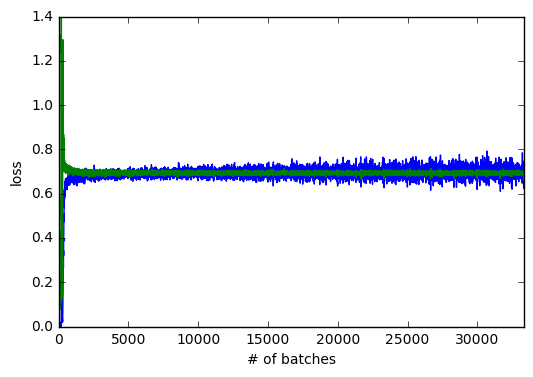

In [123]:
plt.plot(g_loss_history, label='g_loss')
plt.plot(d_loss_history, label='d_loss')
plt.xlabel('# of batches')
plt.ylabel('loss')
plt.xlim((0, len(g_loss_history)))

In [130]:
from IPython.display import Image

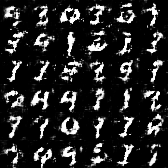

In [136]:
Image('generated_images/epoch-0000.png', width=320, height=320)

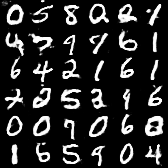

In [137]:
Image('generated_images/epoch-0019.png', width=320, height=320)